## Setup

In [1]:
%matplotlib inline

In [2]:
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import matplotlib.pyplot as plt, xgboost as xgb, operator, random, pickle

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from kevin_utils2 import *

In [4]:
np.set_printoptions(threshold=50, edgeitems=20)

In [5]:
limit_mem()

In [6]:
from isoweek import Week
from pandas_summary import DataFrameSummary

In [7]:
df = pd.read_csv('nflx_technicals.csv', index_col=0)
df["Date"] = pd.to_datetime(df.Date)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502 entries, 501 to 0
Data columns (total 18 columns):
Date          502 non-null datetime64[ns]
Open          502 non-null float64
High          502 non-null float64
Low           502 non-null float64
Close         502 non-null float64
Volume        502 non-null int64
Year          502 non-null int64
Month         502 non-null int64
Week          502 non-null int64
Day           502 non-null int64
DayOfWeek     502 non-null int64
macd          469 non-null float64
macdsignal    469 non-null float64
macdhist      469 non-null float64
RSI           488 non-null float64
ADX           475 non-null float64
ATR           488 non-null float64
EMA_30        473 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(6)
memory usage: 74.5 KB


In [9]:
df.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Week,Day,DayOfWeek,macd,macdsignal,macdhist,RSI,ADX,ATR,EMA_30
501,2015-11-23,124.30,126.20,121.66,125.03,15670283,2015,11,48,23,1,0.597221,1.477072,-0.879851,NaN,NaN,NaN,NaN
500,2015-11-24,123.97,124.66,120.03,123.31,18317565,2015,11,48,24,2,0.826057,1.697035,-0.870978,NaN,NaN,NaN,NaN
499,2015-11-25,124.23,125.20,122.36,124.16,10980677,2015,11,48,25,3,0.870919,1.914779,-1.043860,NaN,NaN,NaN,NaN
498,2015-11-27,123.85,126.39,123.59,125.44,6644280,2015,11,48,27,5,1.260675,2.175744,-0.915069,NaN,NaN,NaN,NaN
497,2015-11-30,126.03,126.60,122.89,123.33,13718932,2015,11,49,30,1,1.374282,2.404512,-1.030230,NaN,NaN,NaN,NaN


## Shift columns based on the number of days to predict

In [10]:
mask = ~(df.columns.isin(['Date','Close','Year','Month','Week','Day','DayOfWeek']))

cols_to_shift = df.columns[mask]

df[cols_to_shift] = df.loc[:,mask].shift(-7)

In [11]:
df1=df[:-7]

In [12]:
df1.head()

,Date,Open,High,Low,Close,Volume,Year,Month,Week,Day,DayOfWeek,macd,macdsignal,macdhist,RSI,ADX,ATR,EMA_30
501,2015-11-23,129.62,132.20,126.39,125.03,26647260.0,2015,11,48,23,1,2.548631,3.147483,-0.598852,NaN,NaN,NaN,NaN
500,2015-11-24,127.00,130.99,125.75,123.31,20250411.0,2015,11,48,24,2,2.833599,3.297196,-0.463597,NaN,NaN,NaN,NaN
499,2015-11-25,131.65,133.27,122.75,124.16,23351610.0,2015,11,48,25,3,3.212106,3.413095,-0.200989,NaN,NaN,NaN,NaN
498,2015-11-27,121.51,128.24,121.10,125.44,18591147.0,2015,11,48,27,5,3.216787,3.463342,-0.246555,NaN,NaN,NaN,NaN
497,2015-11-30,127.70,128.78,122.33,123.33,17788797.0,2015,11,49,30,1,3.188192,3.524981,-0.336789,NaN,NaN,NaN,NaN


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 501 to 7
Data columns (total 18 columns):
Date          495 non-null datetime64[ns]
Open          495 non-null float64
High          495 non-null float64
Low           495 non-null float64
Close         495 non-null float64
Volume        495 non-null float64
Year          495 non-null int64
Month         495 non-null int64
Week          495 non-null int64
Day           495 non-null int64
DayOfWeek     495 non-null int64
macd          462 non-null float64
macdsignal    462 non-null float64
macdhist      462 non-null float64
RSI           488 non-null float64
ADX           475 non-null float64
ATR           488 non-null float64
EMA_30        473 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(5)
memory usage: 73.5 KB


## XGBoost Data Prep

In [14]:
joined=df1

In [15]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

In [16]:
contin_vars = ['High','Low', 'Volume',
   'Open','EMA_30','RSI','macd','macdsignal','macdhist','ADX','ATR','DayOfWeek','Month','Day','Week','Year']

In [17]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [19]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


16

In [20]:
n = len(joined)

In [21]:
samp_size = n
np.random.seed(42)

In [22]:
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [23]:
joined_samp = joined.iloc[idxs].set_index(['Date'])
joined_samp = joined.set_index("Date")

In [24]:
joined_samp.head()

,Open,High,Low,Close,Volume,Year,Month,Week,Day,DayOfWeek,macd,macdsignal,macdhist,RSI,ADX,ATR,EMA_30
Date,,,,,,,,,,,,,,,,,
2015-11-23,129.62,132.20,126.39,125.03,26647260.0,2015,11,48,23,1,2.548631,3.147483,-0.598852,0.0,0.0,0.0,0.0
2015-11-24,127.00,130.99,125.75,123.31,20250411.0,2015,11,48,24,2,2.833599,3.297196,-0.463597,0.0,0.0,0.0,0.0
2015-11-25,131.65,133.27,122.75,124.16,23351610.0,2015,11,48,25,3,3.212106,3.413095,-0.200989,0.0,0.0,0.0,0.0
2015-11-27,121.51,128.24,121.10,125.44,18591147.0,2015,11,48,27,5,3.216787,3.463342,-0.246555,0.0,0.0,0.0,0.0
2015-11-30,127.70,128.78,122.33,123.33,17788797.0,2015,11,49,30,1,3.188192,3.524981,-0.336789,0.0,0.0,0.0,0.0


In [25]:
train_ratio = 0.8
train_size = int(samp_size * train_ratio)

In [26]:
joined_train = joined_samp[:train_size]
joined_valid = joined_samp[train_size:]
len(joined_train),len(joined_valid)

(396, 99)

In [27]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [28]:
#joined_valid.drop('Close',axis=1,inplace=True)

In [29]:
joined_valid.head()

,Open,High,Low,Close,Volume,Year,Month,Week,Day,DayOfWeek,macd,macdsignal,macdhist,RSI,ADX,ATR,EMA_30
Date,,,,,,,,,,,,,,,,,
2017-06-21,149.76,150.71,148.42,155.03,5213315.0,2017,6,25,21,3,2.934275,2.277692,0.656583,39.043779,27.350869,3.938924,155.149197
2017-06-22,149.80,150.45,145.80,154.89,3908215.0,2017,6,25,22,4,2.648369,2.113546,0.534823,34.717652,27.934862,3.989715,154.569894
2017-06-23,146.58,148.26,145.58,158.02,4627803.0,2017,6,25,23,5,2.355909,1.979840,0.376069,38.005436,28.519030,3.896164,154.120868
2017-06-26,146.13,147.27,144.25,157.50,5486482.0,2017,6,26,26,1,2.026756,1.885823,0.140933,36.153528,29.316595,3.857866,153.613070
2017-06-27,146.65,150.75,146.65,151.03,5561263.0,2017,6,26,27,2,1.849012,1.850590,-0.001578,44.560359,28.699294,3.903733,153.391582


In [30]:
#setting up data for graph
joined_valid2=joined_valid
joined_valid2['Date'] = joined_valid2.index
joined_valid2 = joined_valid[['Date','Close']]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
y_train_orig = joined_train.Close
y_valid_orig = joined_valid.Close

In [33]:
y_train = y_train_orig
y_valid = y_valid_orig

## XGBOOST

In [34]:
X_train = np.concatenate([contin_map_train], axis=1)

In [35]:
X_valid = np.concatenate([contin_map_valid], axis=1)


In [36]:
all_vars = contin_vars

In [64]:
params = {"objective": "reg:linear",
          "eta": 0.6,
          "max_depth": 20,
          "subsample": 0.6,
          "colsample_bytree": 0.6,
          "silent": 1,
          "booster":"gblinear"
          }

In [65]:
xdata = xgboost.DMatrix(X_train, y_train, feature_names=all_vars)
xdata_val = xgboost.DMatrix(X_valid, y_valid, feature_names=all_vars)


In [66]:
gbm = xgb.train(params, xdata)

In [67]:
gbm.eval(xdata_val)


b'[0]\teval-rmse:7.426252'

## Visualize Predictions

In [68]:
joined_valid2.head()

,Date,Close
Date,,
2017-06-21,2017-06-21,155.03
2017-06-22,2017-06-22,154.89
2017-06-23,2017-06-23,158.02
2017-06-26,2017-06-26,157.50
2017-06-27,2017-06-27,151.03


In [69]:
test_probs = gbm.predict(xdata_val)

In [70]:
submission = pd.DataFrame({"Date": joined_valid2["Date"], "Prediction": test_probs})


In [71]:
#joined_valid2.drop('Date',axis=1,inplace=True)
#submission.drop('Date',axis=1,inplace=True)

In [72]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

In [73]:
joined3=join_df(joined_valid2,submission,"Date")
len(joined3[joined3.Prediction.isnull()])


0

In [74]:
joined3 = joined3.set_index("Date")
joined3.head()

,Close,Prediction
Date,,
2017-06-21,155.03,152.586975
2017-06-22,154.89,153.450424
2017-06-23,158.02,150.374527
2017-06-26,157.50,149.241684
2017-06-27,151.03,148.880630


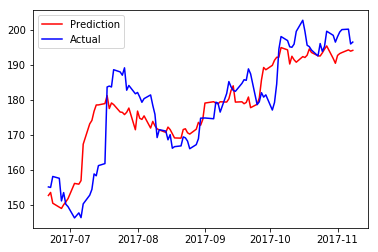

In [75]:
import matplotlib.pyplot as plt2

plt2.plot(joined3['Prediction'], color='red', label='Prediction')
plt2.plot(joined3['Close'], color='blue', label='Actual')
plt2.legend(loc='upper left')
plt2.show()